# Imports

In [2]:
%matplotlib inline
    
import numpy as np

from astropy.table import Column
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm

import corner
import model_flux_ratio as mfr

In [3]:
import importlib
importlib.reload(mfr)

<module 'model_flux_ratio' from '/Users/thsyu/Software/Yp/model_flux_ratio.py'>

In [4]:
import os

print (os.getcwd())

/Users/thsyu/Software/Yp


We have our version of the MCMC that should the *best* we can do to reproduce Erik's 2013 primordial helium abundance analysis work (AOS 2013) using only optical data -- this is called 'ours_base'. It includes:

- hydrogen emissivities from Hummer & Storey 1987, using the reparameterization from AOS 2010
- helium emissivities from Porter 2012, assuming linear interpolation with RectBivariateSpline
- reddening curve from SMC

We want to then make tweaks to the above components and compare the results of those MCMCs with 'ours_base':
- 'ours_CCMred': reddening curve from Cardelli, Clayton, & Mathis 1989
- 'ours_S2018_11': hydrogen emissivities from Storey 2018, using linear interpolation with RBS
- 'ours_S2018_33': hydrogen emissivities from Storey 2018, using cubic interpolation with RBS

And maybe/eventually:
- 'ours_P2012_33': helium emissivities from Porter 2012, using cubic interpolation with RBS
- hydrogen emissivities using a PCA then RBS
- adding HeI10830

# Read in MCMC results

In [5]:
# Names of systems in AOS2015 that "qualified" for helium abundance measurements
qualifying = ['CGCG 007-025 (No.  2)', 'I Zw 18 SE 1', 'Mrk  209', 'Mrk  450 (No.  1)', 'Mrk  71 (No.  1)', \
             'SBS 0335-052E1', 'SBS 0335-052E3', 'SBS 0940+544 2', 'SBS 1030+583', 'SBS 1135+581', \
             'SBS 1152+579', 'Mrk  59', 'SBS 1415+437 (No.  2)', 'SBS 1415+437 (No.  1) 3', 'Tol 65']

qualifying.remove('SBS 1415+437 (No.  2)') # No HeI4027 for this system (they're measured to be 0)

## Store MCMC recovered parameters

In [8]:
# Different versions of the MCMC results so far
diffs = ['ours_base', 'ours_CCMred', 'ours_S2018_11', 'ours_S2018_33']

nwalkers = 500
nmbr = 1000
burnin = int(0.8*nmbr) #int(0.1*nmbr)

num = nwalkers * ( nmbr-burnin )

In [9]:
base_yplus = np.zeros((len(qualifying),num))
base_temp = np.zeros((len(qualifying),num))
base_dens = np.zeros((len(qualifying),num))
base_cHb = np.zeros((len(qualifying),num))
base_aH = np.zeros((len(qualifying),num))
base_aHe = np.zeros((len(qualifying),num))
base_tauHe = np.zeros((len(qualifying),num))
base_xi = np.zeros((len(qualifying),num))

In [10]:
CCMred_yplus = np.zeros((len(qualifying),num))
CCMred_temp = np.zeros((len(qualifying),num))
CCMred_dens = np.zeros((len(qualifying),num))
CCMred_cHb = np.zeros((len(qualifying),num))
CCMred_aH = np.zeros((len(qualifying),num))
CCMred_aHe = np.zeros((len(qualifying),num))
CCMred_tauHe = np.zeros((len(qualifying),num))
CCMred_xi = np.zeros((len(qualifying),num))

In [11]:
S2018_11_yplus = np.zeros((len(qualifying),num))
S2018_11_temp = np.zeros((len(qualifying),num))
S2018_11_dens = np.zeros((len(qualifying),num))
S2018_11_cHb = np.zeros((len(qualifying),num))
S2018_11_aH = np.zeros((len(qualifying),num))
S2018_11_aHe = np.zeros((len(qualifying),num))
S2018_11_tauHe = np.zeros((len(qualifying),num))
S2018_11_xi = np.zeros((len(qualifying),num))

In [12]:
S2018_33_yplus = np.zeros((len(qualifying),num))
S2018_33_temp = np.zeros((len(qualifying),num))
S2018_33_dens = np.zeros((len(qualifying),num))
S2018_33_cHb = np.zeros((len(qualifying),num))
S2018_33_aH = np.zeros((len(qualifying),num))
S2018_33_aHe = np.zeros((len(qualifying),num))
S2018_33_tauHe = np.zeros((len(qualifying),num))
S2018_33_xi = np.zeros((len(qualifying),num))

In [30]:
chisq = np.zeros((len(qualifying), 10)) # 10 is number of emission lines used in analysis
# Also equal to len(input_vals) which comes on later in this block

for d in range(len(diffs)):
    
    for obj in range(len(qualifying)):
        name = str(qualifying[obj].replace(' ', '').replace('(','').replace('-', '').replace(')','').replace('.', ''))
        
        # Load .npy file
        ndim = 8
        onevar = -1

#        nwalkers = 500
#        nmbr = 1000
#        burnin = int(0.8*nmbr) #int(0.1*nmbr)

        chains = np.load('test_data/'+diffs[d]+'/'+name+'_500walkers_1000steps.npy')
        samples = chains[:, burnin:, :].reshape((-1, ndim))

#        prenams = ['y+', 'temperature', '$log(n_{e})$', 'c(H\\beta)', '$a_{H}$', '$a_{He}$', '$\\tau_{He}', '$log(\\xi)$'] #'$n_{HI}$']

        y_plus_mcmc, temp_mcmc, log_dens_mcmc, c_Hb_mcmc, a_H_mcmc, a_He_mcmc, tau_He_mcmc, log_xi_mcmc = map(
            lambda v: (v[1], v[2] - v[1], v[1] - v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

        # Save our MCMC parameters into an array
        if diffs[d] == 'ours_base':
            base_yplus[obj] = chains[:,burnin:,0].reshape(-1)
            base_temp[obj] = chains[:,burnin:,1].reshape(-1)
            base_dens[obj] = chains[:,burnin:,2].reshape(-1)
            base_cHb[obj] = chains[:,burnin:,3].reshape(-1)
            base_aH[obj] = chains[:,burnin:,4].reshape(-1)
            base_aHe[obj] = chains[:,burnin:,5].reshape(-1)
            base_tauHe[obj] = chains[:,burnin:,6].reshape(-1)
            base_xi[obj] = chains[:,burnin:,7].reshape(-1)
        elif diffs[d] == 'ours_CCMred':
            CCMred_yplus[obj] = chains[:,burnin:,0].reshape(-1)
            CCMred_temp[obj] = chains[:,burnin:,1].reshape(-1)
            CCMred_dens[obj] = chains[:,burnin:,2].reshape(-1)
            CCMred_cHb[obj] = chains[:,burnin:,3].reshape(-1)
            CCMred_aH[obj] = chains[:,burnin:,4].reshape(-1)
            CCMred_aHe[obj] = chains[:,burnin:,5].reshape(-1)
            CCMred_tauHe[obj] = chains[:,burnin:,6].reshape(-1)
            CCMred_xi[obj] = chains[:,burnin:,7].reshape(-1)
        elif diffs[d] == 'ours_S2018_11':
            S2018_11_yplus[obj] = chains[:,burnin:,0].reshape(-1)
            S2018_11_temp[obj] = chains[:,burnin:,1].reshape(-1)
            S2018_11_dens[obj] = chains[:,burnin:,2].reshape(-1)
            S2018_11_cHb[obj] = chains[:,burnin:,3].reshape(-1)
            S2018_11_aH[obj] = chains[:,burnin:,4].reshape(-1)
            S2018_11_aHe[obj] = chains[:,burnin:,5].reshape(-1)
            S2018_11_tauHe[obj] = chains[:,burnin:,6].reshape(-1)
            S2018_11_xi[obj] = chains[:,burnin:,7].reshape(-1)
        elif diffs[d] == 'ours_S2018_33':
            S2018_33_yplus[obj] = chains[:,burnin:,0].reshape(-1)
            S2018_33_temp[obj] = chains[:,burnin:,1].reshape(-1)
            S2018_33_dens[obj] = chains[:,burnin:,2].reshape(-1)
            S2018_33_cHb[obj] = chains[:,burnin:,3].reshape(-1)
            S2018_33_aH[obj] = chains[:,burnin:,4].reshape(-1)
            S2018_33_aHe[obj] = chains[:,burnin:,5].reshape(-1)
            S2018_33_tauHe[obj] = chains[:,burnin:,6].reshape(-1)
            S2018_33_xi[obj] = chains[:,burnin:,7].reshape(-1)
        
        # Compare input versus output emission line flux ratios and their relative errors
        input_vals = Table.read('test_data/'+name, format='ascii', delimiter=' ')

        # Generate emission line ratios based on our MCMC parameters
        mfr.generate_emission_line_ratio('test_data/'+diffs[d]+'/'+name+'_MCMCoutput', [3890.166, 4027.328, 4102.891, 4341.684, 4472.755, 4862.721, 5877.299, 6564.612, 6679.994, 7067.198], \
                input_vals['EW'], input_vals['EW'][np.where(input_vals['Wavelength']==4862.721)[0]][0], \
                y_plus_mcmc[0], temp_mcmc[0], log_dens_mcmc[0], c_Hb_mcmc[0], a_H_mcmc[0], a_He_mcmc[0], tau_He_mcmc[0], log_xi_mcmc[0])

        # Output values
        output_vals = Table.read('test_data/'+diffs[d]+'/'+name+'_MCMCoutput', format='ascii', delimiter=' ')

        # Calculate chi-squared value
        for emline in range(len(input_vals['Flux Ratio'])):
            chisq[obj][emline] = ( (output_vals['Flux Ratio'][emline] - input_vals['Flux Ratio'][emline])**2 ) \
                            / (input_vals['Flux Ratio Errors'][emline]**2)

        print (name, chisq[obj], np.sum(chisq[obj]), '\n')

CGCG007025No2 [4.73219723e-01 1.80441465e-01 2.16994306e+00 1.97001353e+00
 1.44056567e-01 0.00000000e+00 5.65519638e-01 8.72532574e-01
 1.30790913e-01 1.36586249e-03] 6.507883342346438 

IZw18SE1 [1.10993617 0.05441803 0.01713053 0.11354363 0.05549173 0.
 0.30048235 0.26086077 0.01404437 0.00398215] 1.929889722352859 

Mrk209 [1.87196085e-03 3.22399672e-04 2.20994823e-02 1.51959245e-01
 2.36016452e-03 0.00000000e+00 3.25784676e-01 4.55492147e-01
 1.05007262e-01 1.73370813e-04] 1.065070707506429 

Mrk450No1 [0.31323575 0.01909539 1.12014991 3.02493057 0.26724024 0.
 0.35300001 0.02722356 0.00524438 1.10931574] 6.239435546103749 

Mrk71No1 [0.00881874 0.06982208 0.22769464 0.4139371  0.38748289 0.
 0.52502533 0.20452389 0.61983402 0.31970414] 2.776842835758561 

SBS0335052E1 [0.00168099 0.01800542 0.13055636 0.53138245 0.14878519 0.
 0.43183019 0.1826311  0.00847041 0.13906183] 1.5924039419044558 

SBS0335052E3 [0.05800775 0.01995718 0.01798765 5.12563425 0.15270452 0.
 1.23819683 0.929

Tol65 [0.25348756 0.00816029 0.18257531 0.71936803 0.24501459 0.
 1.69907936 0.01984234 0.51279341 0.79805821] 4.438379098280202 



# Calculate Yp from the recovered y+ values

## Load Erik's work

In [14]:
aops2013_mcmcout = Table.read('/Users/thsyu/Software/Yp/test_data/aops2013_mcmcoutput', format='ascii', delimiter=' ')
aos2015_mcmcout = Table.read('/Users/thsyu/Software/Yp/test_data/aos2015_mcmcoutput', format='ascii', delimiter=' ')

### Plots of y+, Y

### System vs y+ (compare our 4 methods)

In [15]:
color = cm.jet(np.linspace(0,1,len(qualifying)))

In [22]:
np.mean(base_yplus[8])

0.07811565938486727

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


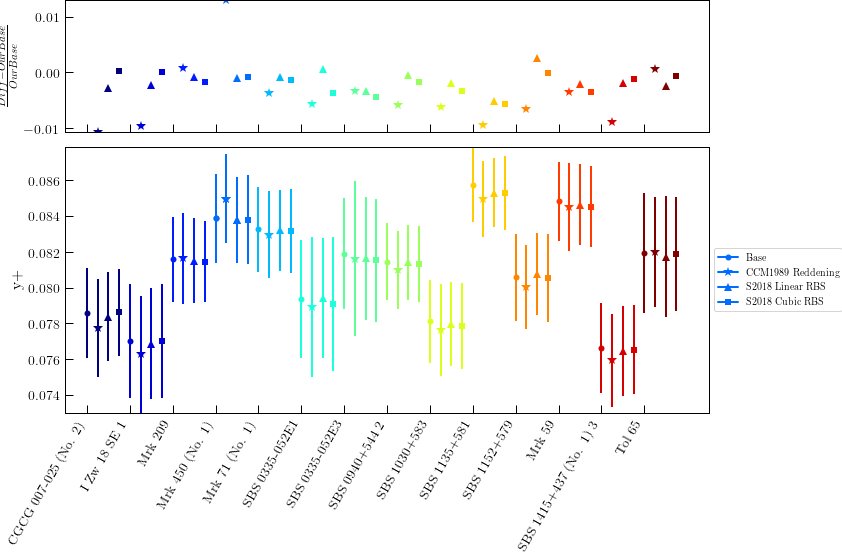

In [31]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))    
    
    ax1.plot(obj+0.25, ((np.mean(CCMred_yplus[obj]))-(np.mean(base_yplus[obj])))/(np.mean(base_yplus[obj])), marker='*', markersize=10, color=color[obj], label='_nolabel')
    ax1.plot(obj+0.5, ((np.mean(S2018_11_yplus[obj]))-(np.mean(base_yplus[obj])))/(np.mean(base_yplus[obj])), marker='^', markersize=8, color=color[obj], label='_nolabel')
    ax1.plot(obj+0.75, ((np.mean(S2018_33_yplus[obj]))-(np.mean(base_yplus[obj])))/(np.mean(base_yplus[obj])), marker='s', markersize=6, color=color[obj], label='_nolabel')

    if obj == 3:
        ax2.plot(obj, np.mean(base_yplus[obj]), marker='o', color=color[obj], label='Base')
        ax2.plot(obj+0.25, np.mean(CCMred_yplus[obj]), marker='*', markersize=10, color=color[obj], label='CCM1989 Reddening')
        ax2.plot(obj+0.5, np.mean(S2018_11_yplus[obj]), marker='^', markersize=8, color=color[obj], label='S2018 Linear RBS')
        ax2.plot(obj+0.75, np.mean(S2018_33_yplus[obj]),  marker='s', markersize=6, color=color[obj], label='S2018 Cubic RBS')

    ax2.errorbar(obj, np.mean(base_yplus[obj]), yerr = np.std(base_yplus[obj]), marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, np.mean(CCMred_yplus[obj]), yerr = np.std(CCMred_yplus[obj]), marker='*', markersize=10, color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.5, np.mean(S2018_11_yplus[obj]), yerr = np.std(S2018_11_yplus[obj]), marker='^', markersize=8, color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.75, np.mean(S2018_33_yplus[obj]), yerr = np.std(S2018_33_yplus[obj]), marker='s', markersize=6, color=color[obj], label='_nolabel_')

ax1.set_ylabel(r'$\frac{Diff-Our Base}{Our Base}$')

ax2.set_xlim(-0.5, 14.5)
ax2.set_ylabel('y+')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_y+.pdf', overwrite=True)
f.show()

Y = Y_primordial + dY/d(O/H) * (O/H)

Y = 4y(1-Z)/1+4y

y = (y_plus + y_plusplus) * ICF(He+ + He2+) (ICF is for He)

y_plusplus = ????

Z = ????; AOS2010 takes Z=20(O/H), stated in footnote 6

### System vs y+ (AOS2015 and 4 of our methods)

In [34]:
y_pp = np.zeros((len(qualifying), num))
y_pp[0] = np.random.normal(aos2015_mcmcout['y++'][0], aos2015_mcmcout['y++_err'][0], num)
#base_y[0] = base_yplus

In [39]:
y_pp.shape

(14, 100000)

In [41]:
base_yplus.shape

(14, 100000)

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


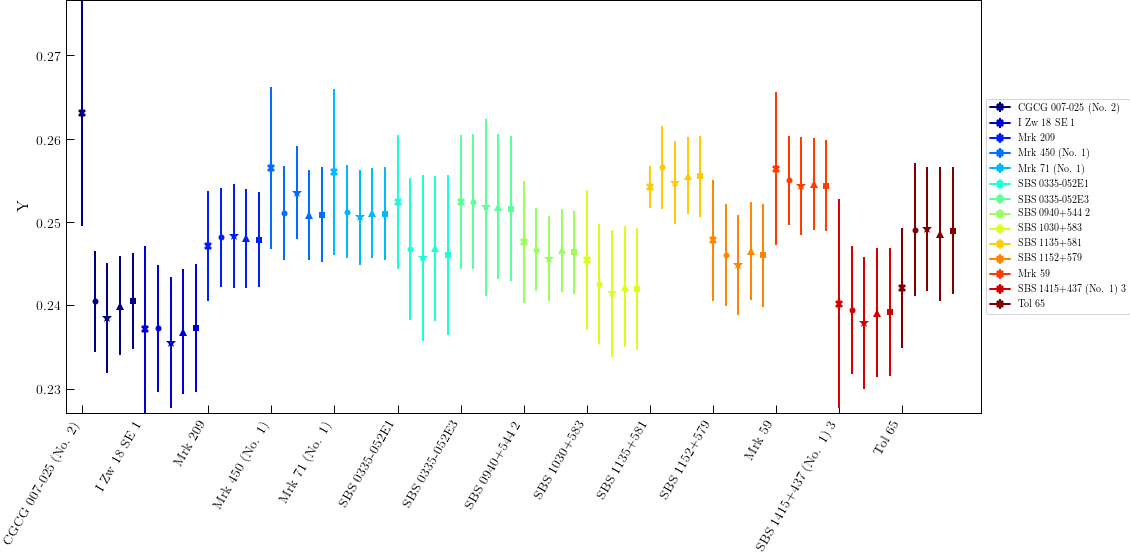

In [113]:
OH = np.zeros((len(qualifying), num))
y_pp = np.zeros((len(qualifying), num))
base_y = np.zeros((len(qualifying), num))
base_Y = np.zeros((len(qualifying), num))
CCMred_y = np.zeros((len(qualifying), num))
CCMred_Y = np.zeros((len(qualifying), num))
S2018_11_y = np.zeros((len(qualifying), num))
S2018_11_Y = np.zeros((len(qualifying), num))
S2018_33_y = np.zeros((len(qualifying), num))
S2018_33_Y = np.zeros((len(qualifying), num))

plt.subplots(figsize=(16,8))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]

    OH[obj] = np.random.normal(aos2015_mcmcout['OH'][aosidx], aos2015_mcmcout['OH_err'][aosidx], num)
    y_pp[obj] = np.random.normal(aos2015_mcmcout['y++'][aosidx], aos2015_mcmcout['y++_err'][aosidx], num)
    
    base_y[obj] = base_yplus[obj] + y_pp[obj]
    base_Y[obj] = ( 4*base_y[obj]*(1 - 20*1e-5*OH[obj] )) / (1 + 4*base_y[obj])
    CCMred_y[obj] = CCMred_yplus[obj] + y_pp[obj]
    CCMred_Y[obj] = ( 4*CCMred_y[obj]*(1 - 20*1e-5*OH[obj] )) / (1 + 4*CCMred_y[obj])
    S2018_11_y[obj] = S2018_11_yplus[obj] + y_pp[obj]
    S2018_11_Y[obj] = ( 4*S2018_11_y[obj]*(1 - 20*1e-5*OH[obj] )) / (1 + 4*S2018_11_y[obj])
    S2018_33_y[obj] = S2018_33_yplus[obj] + y_pp[obj]
    S2018_33_Y[obj] = ( 4*S2018_33_y[obj]*(1 - 20*1e-5*OH[obj] )) / (1 + 4*S2018_33_y[obj])
        
    plt.errorbar(obj, aos2015_mcmcout['Y'][aosidx], yerr=aos2015_mcmcout['Y_err'][aosidx], marker='X', markersize=8, color=color[obj], label=qualifying[obj])
    #plt.errorbar(obj, aops2013_mcmcout['Y'][aopsidx], yerr=aops2013_mcmcout['Y_err'][aopsidx], marker='X', markersize=8, color=color[obj], label=qualifying[obj])
    plt.errorbar(obj+0.2, np.mean(base_Y[obj]), yerr=np.std(base_Y[obj]), marker='o', color=color[obj], linestyle='None', label='_nolabel_')
    plt.errorbar(obj+0.4, np.mean(CCMred_Y[obj]), yerr=np.std(CCMred_Y[obj]), marker='*', markersize=10, color=color[obj], linestyle='None', label='_nolabel_')
    plt.errorbar(obj+0.6, np.mean(S2018_11_Y[obj]), yerr=np.std(S2018_11_Y[obj]), marker='^', markersize=8, color=color[obj], linestyle='None', label='_nolabel_')
    plt.errorbar(obj+0.8, np.mean(S2018_33_Y[obj]), yerr=np.std(S2018_33_Y[obj]), marker='s', markersize=6, color=color[obj], linestyle='None', label='_nolabel_')

plt.xlim(-0.25, len(qualifying)+0.25)
plt.xticks(np.arange(0, len(qualifying)), qualifying, rotation=60, ha='right')
plt.ylabel(r'Y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/system_vs_diff_Y.pdf', overwrite=True)
plt.show()

### Y vs Model for Individual system

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


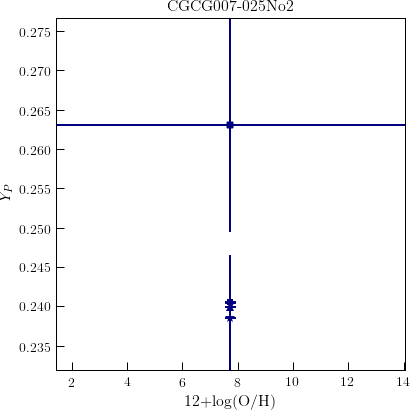

In [47]:
for obj in range(0,1):#len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    
    plt.subplots(figsize=(6,6))
    plt.errorbar(12+np.log10(aos2015_mcmcout[aosidx]['OH']*1e-5), aos2015_mcmcout[aosidx]['Y'], xerr=12+np.log10(aos2015_mcmcout[aosidx]['OH_err']*1e-5), yerr=aos2015_mcmcout[aosidx]['Y_err'], marker='X', markersize=8, color=color[obj])
    plt.errorbar(12+np.log10(np.mean(OH[obj]*1e-5)), np.mean(base_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(base_Y[obj]), marker='o', color=color[obj])
    plt.errorbar(12+np.log10(np.mean(OH[obj]*1e-5)), np.mean(CCMred_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(CCMred_Y[obj]), marker='*', markersize=10, color=color[obj])
    plt.errorbar(12+np.log10(np.mean(OH[obj]*1e-5)), np.mean(S2018_11_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(S2018_11_Y[obj]), marker='^', markersize=8, color=color[obj])
    plt.errorbar(12+np.log10(np.mean(OH[obj]*1e-5)), np.mean(S2018_33_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(S2018_33_Y[obj]), marker='s', markersize=6, color=color[obj])
    
    plt.title(name)
    plt.xlabel(r'12+log(O/H)')
    plt.ylabel(r'$Y_{P}$')
    plt.show()

### O/H vs Y for AOS2015 and our 4 methods

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


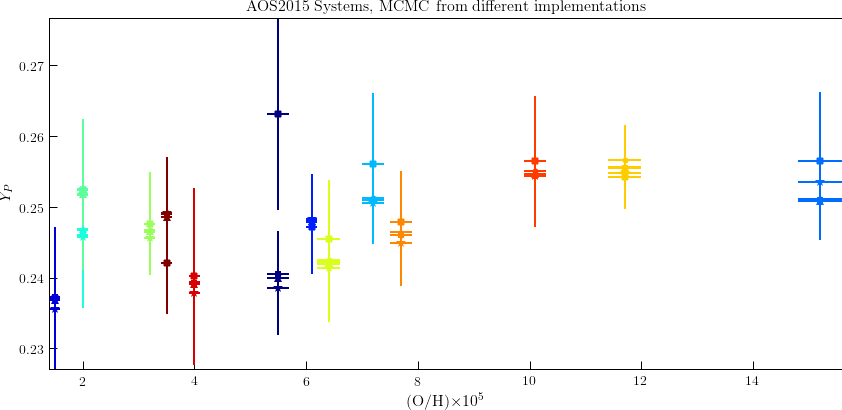

In [48]:
plt.subplots(figsize=(12,6))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    
    plt.errorbar(aos2015_mcmcout[aosidx]['OH'], aos2015_mcmcout[aosidx]['Y'], xerr=aos2015_mcmcout[aosidx]['OH_err'], yerr=aos2015_mcmcout[aosidx]['Y_err'], marker='X', markersize=8, color=color[obj])
    plt.errorbar(np.mean(OH[obj]), np.mean(base_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(base_Y[obj]), marker='o', color=color[obj])
    plt.errorbar(np.mean(OH[obj]), np.mean(CCMred_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(CCMred_Y[obj]), marker='*', markersize=10, color=color[obj])
    plt.errorbar(np.mean(OH[obj]), np.mean(S2018_11_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(S2018_11_Y[obj]), marker='^', markersize=8, color=color[obj])
    plt.errorbar(np.mean(OH[obj]), np.mean(S2018_33_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(S2018_33_Y[obj]), marker='s', markersize=6, color=color[obj])

plt.title('AOS2015 Systems, MCMC from different implementations')
plt.xlabel(r'(O/H)$\times10^{5}$')
plt.ylabel(r'$Y_{P}$')
plt.show()

## Linear Regression to Yp

In [49]:
# Range of OH (x 10^5) values
OH_vals = np.arange(0, 16.5, 0.5 )

### On AOS2015's O/H, Y values

Slope, dY/dOH 0.0006923371273954501 [0.00028231 0.00069116 0.00110411]
Intercept, Yp 0.24591548997668689 [0.24219435 0.24590861 0.24962701]


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


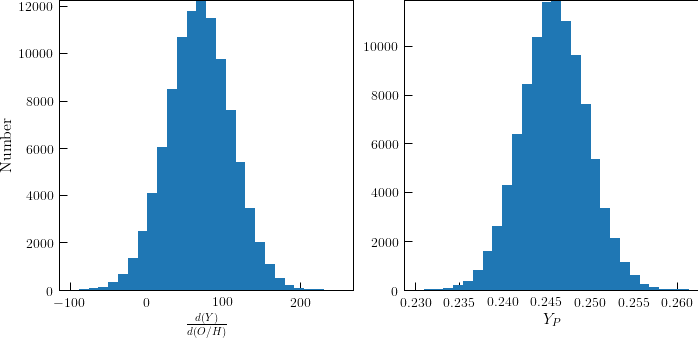

In [135]:
# Do a np.polyfit to AOS2015 reported values of O/H vs Y, MCed, and weighted according to error in Y
our_Yp = np.zeros(num)
our_dYdOH = np.zeros(num)

our_OH = np.array([np.random.normal(m, s, num) for m, s in zip(aos2015_mcmcout['OH'], aos2015_mcmcout['OH_err'])])
our_Y = np.array([np.random.normal(m, s, num) for m, s in zip(aos2015_mcmcout['Y'], aos2015_mcmcout['Y_err'])])

for n in range(num):
    our_linfit = np.polyfit(our_OH[:,n], our_Y[:,n], deg=1, w=1/aos2015_mcmcout['Y_err'])
    our_Yp[n] = our_linfit[1]
    our_dYdOH[n] = our_linfit[0]

print ('Slope, dY/dOH', np.mean(our_dYdOH), np.percentile(our_dYdOH, [16, 50, 84], axis=0))
print ('Intercept, Yp', np.mean(our_Yp), np.percentile(our_Yp, [16, 50, 84], axis=0))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(our_dYdOH*1e5, 30)
ax1.set_xlabel(r'$\frac{d(Y)}{d(O/H)}$')
ax1.set_ylabel('Number')
ax2.hist(our_Yp, 30)
ax2.set_xlabel(r'$Y_{P}$')
f.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


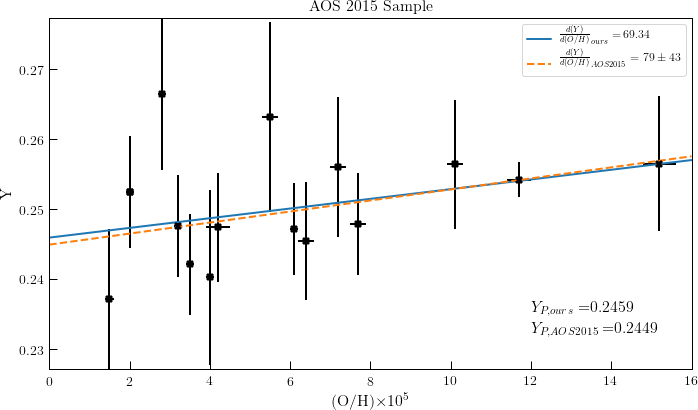

In [67]:
plt.subplots(figsize=(10, 6))
plt.errorbar(aos2015_mcmcout['OH'], aos2015_mcmcout['Y'], xerr=aos2015_mcmcout['OH_err'], yerr=aos2015_mcmcout['Y_err'], marker='X', markersize=8, linestyle='None', color='black', label='_nolabel_')
plt.plot(OH_vals, our_linfit[1]+our_linfit[0]*OH_vals, label=r'$\frac{d(Y)}{d(O/H)}_{ours} =\,$'+str("{:.2f}".format(our_linfit[0]*1e5)))
plt.plot(OH_vals, 0.2449 + 1e-5*79*OH_vals, ls='--', label=r'$\frac{d(Y)}{d(O/H)}_{AOS2015} = 79\pm43$')
plt.text(12, 0.235, r'$Y_{P, ours} = $'+str('{:.4f}'.format(our_linfit[1])), fontsize=16)
plt.text(12, 0.232, r'$Y_{P, AOS2015} = $'+str(0.2449), fontsize=16)

plt.title('AOS 2015 Sample')
plt.xlabel(r'(O/H)$\times10^{5}$')
plt.ylabel(r'Y')
plt.legend(fontsize=12)
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/aos2015_regression.pdf', overwrite=True)
plt.show()

### On our base O/H, Y values

Slope, dY/dOH 0.0007802295713364869 [0.00033504 0.00077672 0.00121866]
Intercept, Yp 0.24253477815001814 [0.23897322 0.24268909 0.24610797]


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


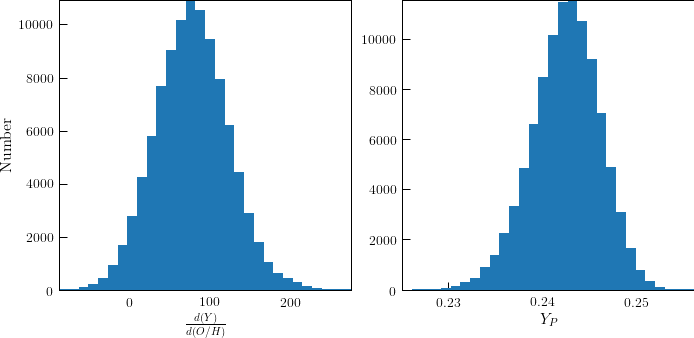

In [73]:
base_Yp = np.zeros(num)
base_dYdOH = np.zeros(num)

for n in range(num):
    base_linfit = np.polyfit(OH[:,n], base_Y[:,n], deg=1)#,w=np.std(base_Y[:,n])
    base_Yp[n] = base_linfit[1]
    base_dYdOH[n] = base_linfit[0]
    
print ('Slope, dY/dOH', np.mean(base_dYdOH), np.percentile(base_dYdOH, [16, 50, 84], axis=0))
print ('Intercept, Yp', np.mean(base_Yp), np.percentile(base_Yp, [16, 50, 84], axis=0))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(base_dYdOH*1e5, 30)
ax1.set_xlabel(r'$\frac{d(Y)}{d(O/H)}$')
ax1.set_ylabel('Number')
ax2.hist(base_Yp, 30)
ax2.set_xlabel(r'$Y_{P}$')
f.show()

Slope, dY/dOH 0.0009205707565240582 [0.0004474  0.00090794 0.00139901]
Intercept, Yp 0.2408847788703558 [0.23691624 0.24105159 0.24484138]


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


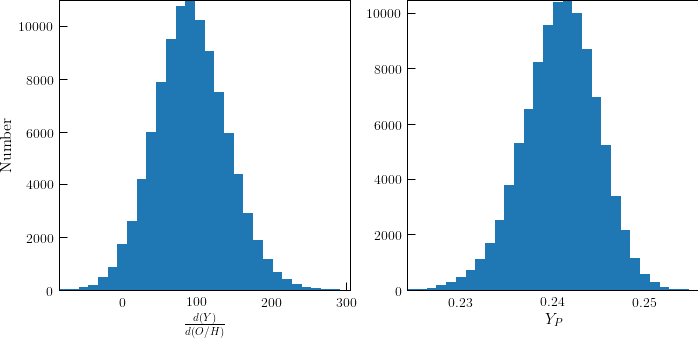

In [74]:
CCMred_Yp = np.zeros(num)
CCMred_dYdOH = np.zeros(num)

for n in range(num):
    CCMred_linfit = np.polyfit(OH[:,n], CCMred_Y[:,n], deg=1)
    CCMred_Yp[n] = CCMred_linfit[1]
    CCMred_dYdOH[n] = CCMred_linfit[0]
    
print ('Slope, dY/dOH', np.mean(CCMred_dYdOH), np.percentile(CCMred_dYdOH, [16, 50, 84], axis=0))
print ('Intercept, Yp', np.mean(CCMred_Yp), np.percentile(CCMred_Yp, [16, 50, 84], axis=0))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(CCMred_dYdOH*1e5, 30)
ax1.set_xlabel(r'$\frac{d(Y)}{d(O/H)}$')
ax1.set_ylabel('Number')
ax2.hist(CCMred_Yp, 30)
ax2.set_xlabel(r'$Y_{P}$')
f.show()

Slope, dY/dOH 0.0007718860079999288 [0.00033614 0.00076712 0.00120645]
Intercept, Yp 0.2422918071962865 [0.23869138 0.24241942 0.24589332]


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


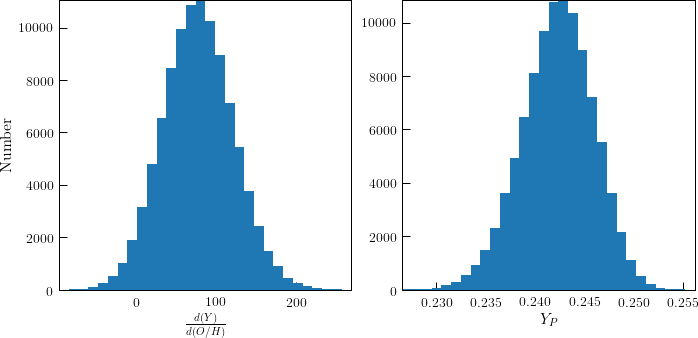

In [75]:
S2018_11_Yp = np.zeros(num)
S2018_11_dYdOH = np.zeros(num)

for n in range(num):
    S2018_11_linfit = np.polyfit(OH[:,n], S2018_11_Y[:,n], deg=1)
    S2018_11_Yp[n] = S2018_11_linfit[1]
    S2018_11_dYdOH[n] = S2018_11_linfit[0]
    
print ('Slope, dY/dOH', np.mean(S2018_11_dYdOH), np.percentile(S2018_11_dYdOH, [16, 50, 84], axis=0))
print ('Intercept, Yp', np.mean(S2018_11_Yp), np.percentile(S2018_11_Yp, [16, 50, 84], axis=0))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(S2018_11_dYdOH*1e5, 30)
ax1.set_xlabel(r'$\frac{d(Y)}{d(O/H)}$')
ax1.set_ylabel('Number')
ax2.hist(S2018_11_Yp, 30)
ax2.set_xlabel(r'$Y_{P}$')
f.show()

Slope, dY/dOH 0.0007685074224665371 [0.0003064  0.00076362 0.00123654]
Intercept, Yp 0.24223400958396818 [0.23846741 0.24237014 0.24599024]


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


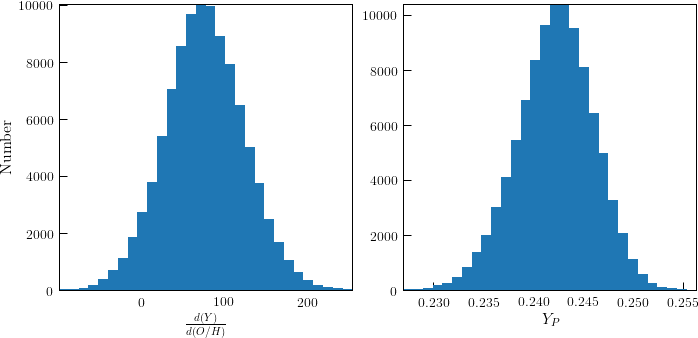

In [81]:
S2018_33_Yp = np.zeros(num)
S2018_33_dYdOH = np.zeros(num)

for n in range(num):
    S2018_33_linfit = np.polyfit(OH[:,n], S2018_33_Y[:,n], deg=1)
    S2018_33_Yp[n] = S2018_33_linfit[1]
    S2018_33_dYdOH[n] = S2018_33_linfit[0]
    
print ('Slope, dY/dOH', np.mean(S2018_33_dYdOH), np.percentile(S2018_33_dYdOH, [16, 50, 84], axis=0))
print ('Intercept, Yp', np.mean(S2018_33_Yp), np.percentile(S2018_33_Yp, [16, 50, 84], axis=0))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
#f.suptitle('Storey 2018 Hydrogen Emissivities, cubic', fontsize=16)
ax1.hist(S2018_33_dYdOH*1e5, 30)
ax1.set_xlabel(r'$\frac{d(Y)}{d(O/H)}$')
ax1.set_ylabel('Number')
ax2.hist(S2018_33_Yp, 30)
ax2.set_xlabel(r'$Y_{P}$')
#f.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/S2018_33_dYdOH_Yp')
f.show()

In [84]:
np.percentile(S2018_33_Yp, [16, 50, 84], axis=0)

array([0.23846741, 0.24237014, 0.24599024])

In [91]:
(np.percentile(S2018_33_Yp,50)-np.percentile(S2018_33_Yp,15.865)),(np.percentile(S2018_33_Yp,84.135)-np.percentile(S2018_33_Yp,50)) 

(0.00392483071948968, 0.00364191879172146)

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


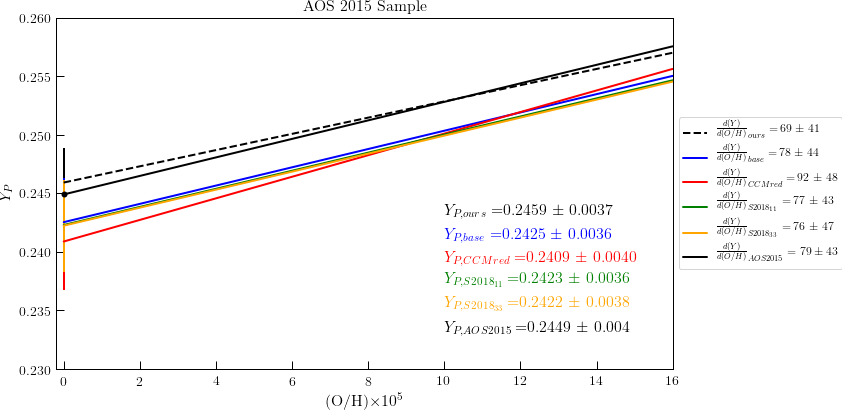

In [137]:
plt.subplots(figsize=(12, 6))
#plt.errorbar(aos2015_mcmcout['OH'], aos2015_mcmcout['Y'], xerr=aos2015_mcmcout['OH_err'], yerr=aos2015_mcmcout['Y_err'], marker='X', markersize=8, linestyle='None', color='black', label='_nolabel_')
plt.plot(OH_vals, np.mean(our_Yp)+np.mean(our_dYdOH)*OH_vals, label=r'$\frac{d(Y)}{d(O/H)}_{ours} =\, $'+str(int(np.mean(our_dYdOH*1e5)))+' $\pm$ '+str(int(np.std(our_dYdOH*1e5))), color='black', ls='--')
plt.plot(OH_vals, np.mean(base_Yp)+np.mean(base_dYdOH)*OH_vals, label=r'$\frac{d(Y)}{d(O/H)}_{base} =\,$'+str(int(np.mean(base_dYdOH*1e5)))+' $\pm$ '+str(int(np.std(base_dYdOH*1e5))), color='blue')
plt.plot(OH_vals, np.mean(CCMred_Yp)+np.mean(CCMred_dYdOH)*OH_vals, label=r'$\frac{d(Y)}{d(O/H)}_{CCMred} =\,$'+str(int(np.mean(CCMred_dYdOH*1e5)))+' $\pm$ '+str(int(np.std(CCMred_dYdOH*1e5))), color='red')
plt.plot(OH_vals, np.mean(S2018_11_Yp)+np.mean(S2018_11_dYdOH)*OH_vals, label=r'$\frac{d(Y)}{d(O/H)}_{S2018_{11}} =\,$'+str(int(np.mean(S2018_11_dYdOH*1e5)))+' $\pm$ '+str(int(np.std(S2018_11_dYdOH*1e5))), color='green')
plt.plot(OH_vals, np.mean(S2018_33_Yp)+np.mean(S2018_33_dYdOH)*OH_vals, label=r'$\frac{d(Y)}{d(O/H)}_{S2018_{33}} =\,$'+str(int(np.mean(S2018_33_dYdOH*1e5)))+' $\pm$ '+str(int(np.std(S2018_33_dYdOH*1e5))), color='orange')
plt.plot(OH_vals, 0.2449 + 1e-5*79*OH_vals, label=r'$\frac{d(Y)}{d(O/H)}_{AOS2015} = 79\pm43$', color='black')

plt.text(10, 0.243, r'$Y_{P, ours} = $'+str('{:.4f}'.format(np.mean(our_Yp)))+' $\pm$ '+str('{:.4f}'.format(np.std(our_Yp))), fontsize=16, color='black')
plt.text(10, 0.241, r'$Y_{P, base} = $'+str('{:.4f}'.format(np.mean(base_Yp)))+' $\pm$ '+str('{:.4f}'.format(np.std(base_Yp))), fontsize=16, color='blue')
plt.text(10, 0.239, r'$Y_{P, CCMred} = $'+str('{:.4f}'.format(np.mean(CCMred_Yp)))+' $\pm$ '+str('{:.4f}'.format(np.std(CCMred_Yp))), fontsize=16, color='red')
plt.text(10, 0.237, r'$Y_{P, S2018_{11}} = $'+str('{:.4f}'.format(np.mean(S2018_11_Yp)))+' $\pm$ '+str('{:.4f}'.format(np.std(S2018_11_Yp))), fontsize=16, color='green')
plt.text(10, 0.235, r'$Y_{P, S2018_{33}} = $'+str('{:.4f}'.format(np.mean(S2018_33_Yp)))+' $\pm$ '+str('{:.4f}'.format(np.std(S2018_33_Yp))), fontsize=16, color='orange')
plt.text(10, 0.233, r'$Y_{P, AOS2015} = $'+str(0.2449)+ ' $\pm$ '+str(0.0040), fontsize=16)
plt.errorbar(0, 0.2449, yerr=0.004, marker='o', color='black')
plt.errorbar(0, np.mean(base_Yp), yerr=[[np.percentile(base_Yp,50)-np.percentile(base_Yp,15.865),np.percentile(base_Yp,84.135)-np.percentile(base_Yp,50)]], color='blue')
plt.errorbar(0, np.mean(CCMred_Yp), yerr=[[np.percentile(CCMred_Yp,50)-np.percentile(CCMred_Yp,15.865),np.percentile(CCMred_Yp,84.135)-np.percentile(CCMred_Yp,50)]], color='red')
plt.errorbar(0, np.mean(S2018_11_Yp), yerr=[[np.percentile(S2018_11_Yp,50)-np.percentile(S2018_11_Yp,15.865),np.percentile(S2018_11_Yp,84.135)-np.percentile(S2018_11_Yp,50)]], color='green')
plt.errorbar(0, np.mean(S2018_33_Yp), yerr=[[np.percentile(S2018_33_Yp,50)-np.percentile(S2018_33_Yp,15.865),np.percentile(S2018_33_Yp,84.135)-np.percentile(S2018_33_Yp,50)]], color='orange')

plt.xlim(-0.2, 16)
plt.ylim(0.23, 0.26)
plt.title('AOS 2015 Sample')
plt.xlabel(r'(O/H)$\times10^{5}$')
plt.ylabel(r'$Y_{P}$')
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/Yp_linear_regression.pdf', overwrite=True)
plt.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


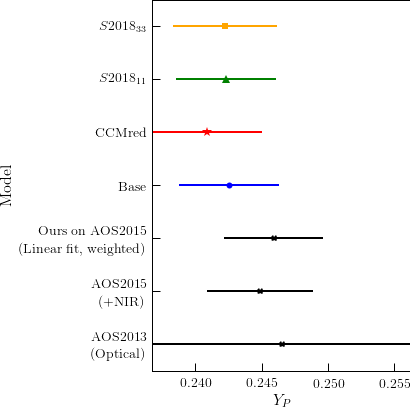

In [144]:
plt.subplots(figsize=(6,6))
plt.errorbar(0.2465, -1, xerr=0.0097, marker='X', color='black') # AOS2013
plt.errorbar(0.2449, 0, xerr=0.004, marker='X', color='black') # AOS 2015
plt.errorbar(np.mean(our_Yp), 1, xerr=[[np.percentile(our_Yp,50)-np.percentile(our_Yp,15.865),np.percentile(our_Yp,84.135)-np.percentile(our_Yp,50)]], marker='X', color='black')
plt.errorbar(np.mean(base_Yp), 2, xerr=[[np.percentile(base_Yp,50)-np.percentile(base_Yp,15.865),np.percentile(base_Yp,84.135)-np.percentile(base_Yp,50)]], marker='o', color='blue')
plt.errorbar(np.mean(CCMred_Yp), 3, xerr=[[np.percentile(CCMred_Yp,50)-np.percentile(CCMred_Yp,15.865),np.percentile(CCMred_Yp,84.135)-np.percentile(CCMred_Yp,50)]], marker='*', markersize=10, color='red')
plt.errorbar(np.mean(S2018_11_Yp), 4, xerr=[[np.percentile(S2018_11_Yp,50)-np.percentile(S2018_11_Yp,15.865),np.percentile(S2018_11_Yp,84.135)-np.percentile(S2018_11_Yp,50)]], marker='^', markersize=8, color='green')
plt.errorbar(np.mean(S2018_33_Yp), 5, xerr=[[np.percentile(S2018_33_Yp,50)-np.percentile(S2018_33_Yp,15.865),np.percentile(S2018_33_Yp,84.135)-np.percentile(S2018_33_Yp,50)]], marker='s', markersize=6, color='orange')

plt.ylim(-1.5, 5.5)
plt.xlabel(r'$Y_{P}$')
plt.ylabel('Model')
plt.yticks(np.arange(-1,6),['AOS2013 \n (Optical)', 'AOS2015 \n (+NIR)', 'Ours on AOS2015 \n (Linear fit, weighted)', 'Base', 'CCMred', r'$S2018_{11}$', r'$S2018_{33}$'])
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/Yp_vs_model.pdf', overwrite=True)
plt.show()
